## Imports 

#### Outside Modeling Functions and Warning Suppression

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Mounted at /content/gdrive


#### Google collab setup

In [2]:
from google.colab import drive, files

drive.mount("/content/gdrive", force_remount=True)
files.upload() #Upload the modeling_functions script to the virtual environment

#Import user defined modeling functions
from modeling_functions import grid_search_cv
from modeling_functions import evaluate_model

Saving modeling_functions.py to modeling_functions.py


#### Training Data Imports

In [3]:
X_train = pd.read_csv('/content/gdrive/MyDrive/capstone/data/X_train.csv',  index_col=0)
y_train = pd.read_csv('/content/gdrive/MyDrive/capstone/data/y_train.csv', index_col=0).values.ravel()

### Dummy Accuracy: always predicts the majority class

In [18]:
dummy_accuracy = len(y_train[y_train == 0].dropna())/ len(y_train)
dummy_accuracy

0.5036330220332101

## Logistic Regression

### Baseline Model: default parameters 

Average accuracy-- test: 0.7582010281612983, train: 0.7585393830141614
Average f1-- test: 0.7446272615417021, train: 0.7449817417136007
Average roc_auc-- test roc_auc: 0.8466362319314656, train: 0.8467749455992573


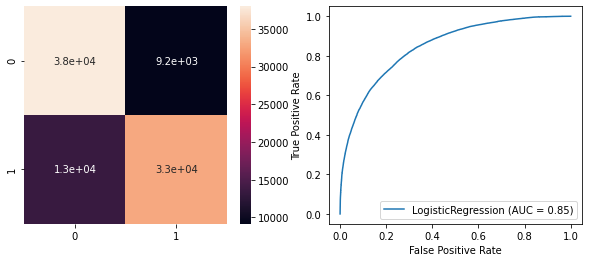

In [83]:
evaluate_model(LogisticRegression(), X_train, y_train)

Overall decent scores. Looks like the baseline model is misclassifing non-cheaters as cheaters.

### Determining the Optimal Penalty Solver

Grid search options:
*   penalty solver algorithms
*   intercept inclusion
*   intercept scaling
*   penalty inclusion
*   regularization strength (inverse)

#### l2 Penalty Grid Search

Average accuracy-- test: 0.7582971902257915, train: 0.7585135596350806
Average f1-- test: 0.7447448770744625, train: 0.7449503415537355
Average roc_auc-- test roc_auc: 0.8466150345519562, train: 0.8467727680855901


{'C': 1e-05,
 'fit_intercept': True,
 'intercept_scaling': 1e-05,
 'penalty': 'none',
 'solver': 'sag',
 'warm_start': True}

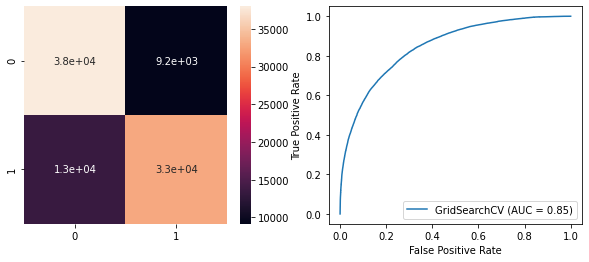

In [6]:
logreg_l2 = LogisticRegression(max_iter=5000, multi_class='ovr')
logreg_l2_param_grid = {
                  'solver':['lbfgs','sag']
                  ,'fit_intercept': [True, False]
                  ,'intercept_scaling': [1e-5,1e-10]
                  ,'penalty':['l2','none']
                  ,'C': [1e-5,1e-10]
                  ,'warm_start': [True, False]
}               
best_params_l2 = grid_search_cv(logreg_l2, logreg_l2_param_grid, X_train, y_train)                  
best_params_l2

Tiny tiny improvement over test accuracy and f1 scores. Tiny tiny decrease in train accuracy and f1 scores.

Looks like an extremely small intercept is better than none at all and that l2 penalty existence isn't doing the trick. 



#### l1 Penalty Grid Search

Finding the best parameters for algorithms that utilize l1 penalties. 

*   l1 algorithms
*   intercept inclusion
*   intercept scaling
*   penalty inclusion
*   regularization strength (inverse)

Average accuracy-- test: 0.758243763431161, train: 0.7584948601998791
Average f1-- test: 0.744674008819193, train: 0.744926986689938
Average roc_auc-- test roc_auc: 0.8466124540051911, train: 0.846769855276501


{'C': 1e-05,
 'fit_intercept': True,
 'intercept_scaling': 1e-05,
 'penalty': 'none',
 'solver': 'saga',
 'warm_start': True}

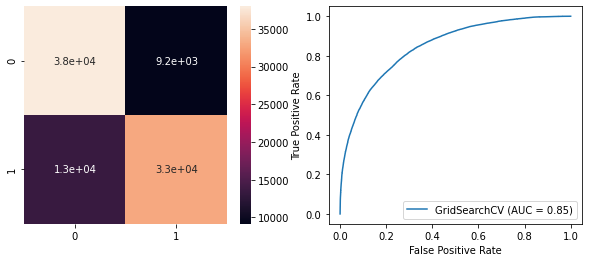

In [7]:
logreg_l1_param_grid = {
                  'solver':['saga', 'liblinear']
                  ,'fit_intercept': [True, False]
                  ,'intercept_scaling': [1e-5,1e-10]
                  ,'penalty':['l1','none']
                  ,'C': [1e-5,1e-10]
                  ,'warm_start': [True, False]
}               
logreg_l1 = LogisticRegression(max_iter=5000, multi_class='ovr')
best_params_l1 = grid_search_cv(logreg_l1, logreg_l1_param_grid, X_train, y_train)                  
best_params_l1

Tiny decrease in all scoring metrics.

Again, a small intercept and inverse regularization parameter is optimal. These will be added as default parameters for the elasticnet penalty model to save processing time.

#### Elasticnet Penalty Grid Search

Average accuracy-- test: 0.7339238441571189, train: 0.7341028557373935
Average f1-- test: 0.6978270732866427, train: 0.6981003575474833
Average roc_auc-- test roc_auc: 0.8103395133526659, train: 0.8103759843058329


{'l1_ratio': 0.05}

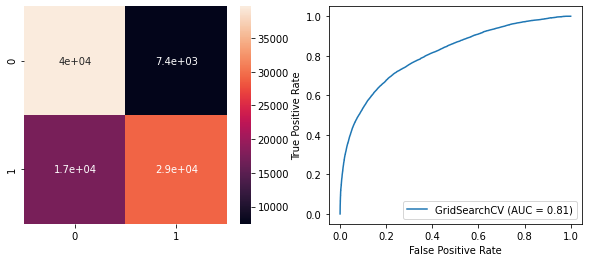

In [4]:
logreg_elasticnet_param_grid = {'l1_ratio': [0.05,0.15,0.25,0.4,0.6]}
logreg_elasticnet = LogisticRegression(max_iter=5000
                              ,multi_class='ovr'
                              ,solver='saga'
                              ,penalty='elasticnet'
                              ,C=1e-5
                              ,warm_start=True
                              ,intercept_scaling=1e-5
                              ,fit_intercept=True)
best_params_elasticnet = grid_search_cv(logreg_elasticnet, logreg_elasticnet_param_grid, X_train, y_train)                  
best_params_elasticnet

The lowest performing model in all accuracy measures. The algorithm preferred a very low l1 ratio for solver penalty.

### Selected parameters

 Although the diffreneces in scoring metrics across all models were small, the parameters that outpreformed all others were:
* C: 1e-05
* fit_intercept: True
* intercept_scaling: 1e-05
* penalty: none
* solver: saga
* warm_start: True

The saga solver seems to be the parameter increased the scoring, since the rest of the parameters were returned as best model parameters for every grid search.